# Exercício 1

## Enunciado

A partir da base de dados:

- Parte 1: Descreva a base de dados descrendo os atributos, numéricos e categóricos, classificando segundo a escala (nominal ou razão) e a cardinalidade (discreta, contínua, binária).

- Parte 2: Descreva cada um dos atributos segundo frequência, mínimo e máximo valor, dia desvios padrão, conforme o caso.

- Parte 3: Avalie os resultados dos processos abaixo, caso sejam utilizados na base de dados, após o processo de classificação com DT ter sido utilizado.
    - limpeza de dados (outlier, missing)
    - normalização/transformação
    - discretização

## Parte 1

Para entender melhor sobre os dados e conseguir classificá-los e descrevê-los, irei fazer uma análise dos mesmos junto a sua descrição fornecida em `dataset_description.txt`.

#### Descrição

https://www.kaggle.com/uciml/german-credit

Context

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

Content

It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

#### Imports

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, chi2

#### Panorama dos dados

In [215]:
df = pd.read_csv('class_german_credit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


Como uma breve interpretação desse resumo dos dados, já podemos ver que há valores faltantes (*missing*) para os atributos `Saving accounts` e `Checking account`.

Além disso, na descrição dada por `dataset_description.txt`, o atributo `Checking account` é dito como numérico, mas acima é dito como `object`, não um tipo numérico como era de se esperar.

Para obter mais informações relevantes acerca dos dado, irei realizar uma análise exploratória sobre cada atributo individualmente.

### Age

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado numérico/quantitativo. Agora irei explorar para obter mais informações desse atributo.

In [216]:
print('--------- descrição estatística ---------')
print(df['Age'].describe())

print('\n--------- valores faltantes ---------')
print(df[df['Age'].isnull()])

--------- descrição estatística ---------
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

--------- valores faltantes ---------
Empty DataFrame
Columns: [Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose, Risk]
Index: []


Como pode ser observado acima, o atributo `Age` se classifica como **quantitativo discreto** e seu nível (escala) de mensuração é **racional**.

Além disso, claramente não há valores faltantes (*missing*) por terem $1000$ valores dentre $1000$ registros e nenhum deles ser nulo.

Podemos perceber também que não há valores discrepantes (*outliers*) por seus valores mínimo e máximo serem, respectivamente, $19$ e $75$.

### Sex

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo texto e que assume apenas dois valores `male` (*masculino*) e `female` (*feminino*).

In [217]:
df['Sex'].value_counts(dropna=False).sort_index()

Sex
female    310
male      690
Name: count, dtype: int64

Como observado acima, o atributo, de fato, assume os dois valores (ou categorias) mencionados anteriormente, com isso se classifica como **quantitativa nominal**.

Além disso, somando as frequências temos $1000$ valores aparecendo nesse atributo sendo que nenhum deles é nulo, então não há valores faltantes (*missing*).

### Job

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo categórico, apesar de ser representado de forma numérica.

In [218]:
df['Job'].value_counts(dropna=False).sort_index()

Job
0     22
1    200
2    630
3    148
Name: count, dtype: int64

Não é possível identificar muito bem as frequências sem consultar o mapeamento em `dataset_description.txt`. Para facilitar a leitura irei fazer o mapeamento direto na contagem de valores.

Mas antes disso, já é possível dizer que se trata de um dado **qualitativo ordinal** e que não há valores faltantes.

In [219]:
job_titles = {
    0: 'Unskilled and non-resident',
    1: 'Unskilled and resident',
    2: 'Skilled',
    3: 'Highly skilled'
}
job_counts = df['Job'].value_counts().sort_index()
job_counts.index = job_counts.index.map(job_titles)
job_counts

Job
Unskilled and non-resident     22
Unskilled and resident        200
Skilled                       630
Highly skilled                148
Name: count, dtype: int64

> Dúvida para investigar: para árvore de decisão, esse campo deverá/poderá permanecer numérico ou deverá ser textual?

> R.: Por essa variável ser ordinal e seus valores estarem adequados com as categorias, i.e., 0 representa o menos qualidicado e 3, o mais qualificado (segue a ordem do menor para o maior), o modelo conseguirá interpretá-la da maneira correta. O problema seria se fosse nominal. O modelo poderia entender que existe uma ordem e certa distância entre as categorias por serem números.

### Housing

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo categórico.

In [220]:
df['Housing'].value_counts(dropna=False).sort_index()

Housing
free    108
own     713
rent    179
Name: count, dtype: int64

Pode-se ver que é um atributo do tipo **qualitativo nominal** e que não há valores faltantes, pois a soma das frequências acima é $1000$.

### Saving account

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo texto.

In [221]:
df['Saving accounts'].value_counts(dropna=False).sort_index()

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
NaN           183
Name: count, dtype: int64

Temos um atributo do tipo **qualitativo ordinal** e que apresenta valores faltantes, 183 registros não apresentam valor para este atributo.

### Checking Account

Como mencionado anteriormente, esse campo é dito como numérico em `dataset_description.txt`, mas no resumo do dataframe é dito como `object`. Irei investigar seus possíveis valores para entender melhor como esse atributo se classifica de fato.

In [222]:
df['Checking account'].value_counts(dropna=False).sort_index()

Checking account
little      274
moderate    269
rich         63
NaN         394
Name: count, dtype: int64

Observando seus valores, podemos ver que é classificado como **qualitativo ordinal** e que há 394 valores faltantes.

### Credit Amount

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo numérico.

In [223]:
print('\n--------- descrição estatística ---------')
print(df['Credit amount'].describe())
print('\n--------- valores faltantes ---------')
print(df[df['Credit amount'].isnull()])


--------- descrição estatística ---------
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: Credit amount, dtype: float64

--------- valores faltantes ---------
Empty DataFrame
Columns: [Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose, Risk]
Index: []


E pelo resumo acima pode-se ver que esse atributo é **quantitativo racional** e não tem valores faltantes.

### Duration

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo numérico.

In [224]:
print('\n--------- descrição estatística ---------')
print(df['Duration'].describe())
print('\n--------- valores faltantes ---------')
print(df[df['Duration'].isnull()])


--------- descrição estatística ---------
count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: Duration, dtype: float64

--------- valores faltantes ---------
Empty DataFrame
Columns: [Age, Sex, Job, Housing, Saving accounts, Checking account, Credit amount, Duration, Purpose, Risk]
Index: []


E pelo resumo acima pode-se ver que esse atributo é **quantitativo racional** e não tem valores faltantes.

### Purpose

Pela descrição em `dataset_description.txt` e no resumo do dataframe, podemos ver que é um dado do tipo textual.

In [225]:
df['Purpose'].value_counts(dropna=False).sort_index()

Purpose
business                97
car                    337
domestic appliances     12
education               59
furniture/equipment    181
radio/TV               280
repairs                 22
vacation/others         12
Name: count, dtype: int64

Pode-se ver que se classifica como **qualitativo nominal** e não há valores faltantes.

### Risk

Por último, iremos avaliar a coluna que contém a informação que queremos que nosso modelo aprenda a inferir. Que diz se uma pessoa é boa (good) ou ruim (bad) com relação ao risco de crédito.

In [226]:
df['Risk'].value_counts(dropna=False).sort_index()

Risk
bad     300
good    700
Name: count, dtype: int64

Percebemos que é **qualitativa ordinal**, uma variável binária, que não tem valores faltantes, mas que está desbalanceada. Isso é um detalhe a ser considerado na hora de treinar o modelo.

### Resumo

Segue abaixo um resumo dos atributos.

In [227]:
resumo_df = pd.DataFrame({
    'atributo': ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
                 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
    'tipo': ['quantitativo racional', 'qualitativa nominal', 'qualitativa ordinal',
             'qualitativa nominal', 'qualitativa ordinal', 'qualitativa ordinal',
             'quantitativo racional', 'quantitativo racional', 'qualitativa nominal', 'qualitativa nominal'],
    'valores faltantes': [0, 0, 0, 0, 183, 394, 0, 0, 0, 0],
    'outliers': ['não', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'não', 'não', 'n/a', 'n/a'],
    'cardinalidade': ['discreta', 'discreta (binária)', 'discreta', 'discreta',
                      'discreta', 'discreta', 'contínua', 'discreta', 'discreta', 'discreta (binária)']
})
resumo_df

,atributo,tipo,valores faltantes,outliers,cardinalidade
0,Age,quantitativo racional,0,não,discreta
1,Sex,qualitativa nominal,0,n/a,discreta (binária)
2,Job,qualitativa ordinal,0,n/a,discreta
3,Housing,qualitativa nominal,0,n/a,discreta
4,Saving accounts,qualitativa ordinal,183,n/a,discreta
5,Checking account,qualitativa ordinal,394,n/a,discreta
6,Credit amount,quantitativo racional,0,não,contínua
7,Duration,quantitativo racional,0,não,discreta
8,Purpose,qualitativa nominal,0,n/a,discreta
9,Risk,qualitativa nominal,0,n/a,discreta (binária)


## Avaliação da Árvore de Decisão

## Definindo as funções a serem utilizadas

### Treinar uma árvore de decisão

In [228]:
def trained_model(X_train, y_train, scorer, show_best_params=False, show_tree=False):
    param_grid = {
        'max_depth': [2, 4, 8, 16, 32, 64, None],
        'min_samples_split': [2, 4, 8, 16, 32, 64],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64]
    }

    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring=scorer,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    
    model = grid_search.best_estimator_

    if show_best_params:
        print('Melhores hiperparâmetros:', grid_search.best_params_)
    
    if show_tree:
        tree.plot_tree(
            model,
            feature_names=X_train.columns,
            class_names=['good', 'bad'],
            filled = True
        )
        plt.show()

    return model

def predict_and_evaluate(model, X_test, y_test):
    # Avaliação no conjunto de teste
    y_pred = model.predict(X_test)

    recall = recall_score(y_test, y_pred, pos_label='bad')
    accuracy = accuracy_score(y_test, y_pred)
    
    print('Relatório:')
    print(f'recall (bad): {recall:.2f}')
    print(f'accuracy: {accuracy:.2f}')

    cm = confusion_matrix(y_test, y_pred, labels=['good', 'bad'])
    plt.figure(figsize=(5,4))
    plt.title('Matriz de Confusão')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()


### Preparação mínima

A árvore de decisão exige uma preparação mínima dos atributos qualitativos. Os mesmo não podem ser textuais, devem ter uma representação numérica ou passível de conversão em tipo numérico. Farei essa preparação nos atributos (qualitativos) listados abaixo.

In [229]:
resumo_df[resumo_df['tipo'].str.contains('qualitativa')]

,atributo,tipo,valores faltantes,outliers,cardinalidade
1,Sex,qualitativa nominal,0,n/a,discreta (binária)
2,Job,qualitativa ordinal,0,n/a,discreta
3,Housing,qualitativa nominal,0,n/a,discreta
4,Saving accounts,qualitativa ordinal,183,n/a,discreta
5,Checking account,qualitativa ordinal,394,n/a,discreta
8,Purpose,qualitativa nominal,0,n/a,discreta
9,Risk,qualitativa nominal,0,n/a,discreta (binária)


### Funções de preparação dos dados

In [ ]:
def prepare_sex(df):
    df_preparado = df.copy()
    df_preparado.loc[df_preparado['Sex'] == 'male', 'Sex'] = False
    df_preparado.loc[df_preparado['Sex'] == 'female', 'Sex'] = True
    df_preparado['Sex'] = df_preparado['Sex'].astype(bool)
    return df_preparado

# Job -> Ja esta representado com numeros da forma correta

def prepare_housing(df):
    df_preparado = df.copy()
    dummies = pd.get_dummies(df_preparado['Housing'])
    df_preparado = pd.concat([df_preparado, dummies], axis=1)
    df_preparado = df_preparado.drop('Housing', axis=1)
    return df_preparado

def prepare_saving_accounts(df):
    # 0 = little, 1 = moderate, 2 = quite rich, 3 = rich
    df_preparado = df.copy()
    df_preparado.loc[df_preparado['Saving accounts'] == 'little', 'Saving accounts'] = 0
    df_preparado.loc[df_preparado['Saving accounts'] == 'moderate', 'Saving accounts'] = 1
    df_preparado.loc[df_preparado['Saving accounts'] == 'quite rich', 'Saving accounts'] = 2
    df_preparado.loc[df_preparado['Saving accounts'] == 'rich', 'Saving accounts'] = 3
    return df_preparado

def prepare_checking_account(df):
    # 0 = little, 1 = moderate, 2 = rich
    df_preparado = df.copy()
    df_preparado.loc[df_preparado['Checking account'] == 'little', 'Checking account'] = 0
    df_preparado.loc[df_preparado['Checking account'] == 'moderate', 'Checking account'] = 1
    df_preparado.loc[df_preparado['Checking account'] == 'rich', 'Checking account'] = 2
    return df_preparado

def prepare_purpose(df):
    df_preparado = df.copy()
    dummies = pd.get_dummies(df_preparado['Purpose'])
    df_preparado = pd.concat([df_preparado, dummies], axis=1)
    df_preparado = df_preparado.drop('Purpose', axis=1)
    return df_preparado

def prepare_all(df_preparado):
    df_preparado = prepare_sex(df_preparado)
    df_preparado = prepare_housing(df_preparado)
    df_preparado = prepare_saving_accounts(df_preparado)
    df_preparado = prepare_checking_account(df_preparado)
    df_preparado = prepare_purpose(df_preparado)
    return df_preparado

df_preparado = prepare_all(df.copy())
df_preparado.head()

,Age,Sex,Job,Saving accounts,Checking account,Credit amount,Duration,Risk,free,own,rent,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
0,67,False,2,NaN,0,1169,6,good,False,True,False,False,False,False,False,False,True,False,False
1,22,True,2,0,1,5951,48,bad,False,True,False,False,False,False,False,False,True,False,False
2,49,False,1,0,NaN,2096,12,good,False,True,False,False,False,False,True,False,False,False,False
3,45,False,2,0,0,7882,42,good,True,False,False,False,False,False,False,True,False,False,False
4,53,False,2,0,0,4870,24,bad,True,False,False,False,True,False,False,False,False,False,False


### Avaliação

Quero que o modelo acerte mais na classificação de pessoas que são más (`bad`) devedoras. Isso para garantir que o modelo não diga que uma pessoa é boa devedora, i.e., pagará seu empréstimo, quando a pessoa não é e não pagará. Dessa forma, diminui as chances de sair no prejuízo.
Claro que não posso deixar de observar também a classificação dos bons (`good`) devedores, pois se o modelo os classifica errado, é dinheiro que deixa de entrar.

### Sem Tratamento dos Dados

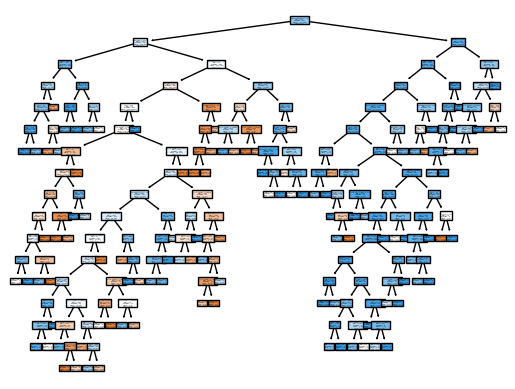

Relatório:
recall (bad): 0.50
accuracy: 0.65


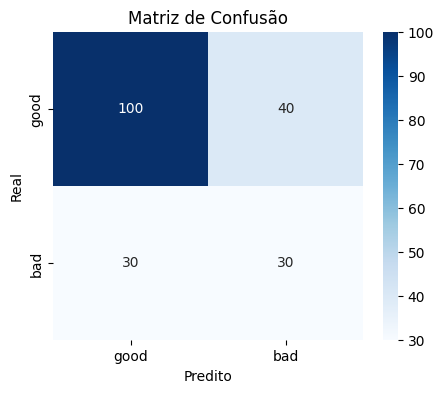

In [ ]:
def execute_experiment(df, show_best_params=False, show_tree=False):
    X = df.drop('Risk', axis=1)
    y = df['Risk']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scorer = make_scorer(recall_score, pos_label='bad')

    model = trained_model(
        X_train,
        y_train,
        scorer,
        show_best_params=show_best_params,
        show_tree=show_tree
    )
    predict_and_evaluate(model, X_test, y_test)

df_preparado = prepare_all(df.copy())
execute_experiment(df_preparado, show_tree=True)

Sem tratamento de dados, temos um `recall` de $0.5$ e `accuracy` de $0.65$. Não foi um resultado promissor, mas sinto que pode melhorar.

### Limpando os Dados

Como não há *outliers* nessa base, não preciso me preocupar com o tratamento desse tipo de problema. Mas há $183$ valores faltantes para `Saving accounts` e $394$ para `Checking account`.

#### Removendo Linhas

Pela base de dados ter poucos registros ($1000$), acredito que seguir pela estratégia de remoção de linhas irá mais atrapalhar o modelo do que ajudar, mas não custa fazer a avaliação. Para isso, irei avaliar dois pontos que me preocupam:

1. Quantos registros terei da base se remover registros com valores faltantes?
2. A proporcionalidade entre as classes de `Risk` se manterá?

Farei a avaliação desses dois pontos para os seguintes cenários:
1. Removendo o atributo `Saving accounts`
2. Removendo o atributo `Checking account`
3. Removendo ambos.

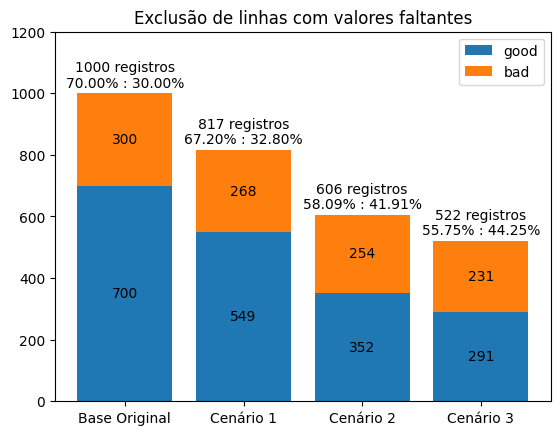

In [232]:
total = len(df)
risk_good = len(df[df['Risk'] == 'good'])
risk_bad = len(df[df['Risk'] == 'bad'])

df_sem_saving = df.dropna(subset=['Saving accounts'])
risk_good_sem_saving = len(df_sem_saving[df_sem_saving['Risk'] == 'good'])
risk_bad_sem_saving = len(df_sem_saving[df_sem_saving['Risk'] == 'bad'])

df_sem_checking = df.dropna(subset=['Checking account'])
risk_good_sem_checking = len(df_sem_checking[df_sem_checking['Risk'] == 'good'])
risk_bad_sem_cheking = len(df_sem_checking[df_sem_checking['Risk'] == 'bad'])

df_sem_ambos = df.dropna(subset=['Saving accounts', 'Checking account'])
risk_good_sem_ambos = len(df_sem_ambos[df_sem_ambos['Risk'] == 'good'])
risk_bad_sem_ambos = len(df_sem_ambos[df_sem_ambos['Risk'] == 'bad'])

rotulos = ('Base Original', 'Cenário 1', 'Cenário 2', 'Cenário 3')
risks = {
    'good': [risk_good, risk_good_sem_saving, risk_good_sem_checking, risk_good_sem_ambos],
    'bad': [risk_bad, risk_bad_sem_saving, risk_bad_sem_cheking, risk_bad_sem_ambos]
}

fig, ax = plt.subplots()
ax.set_ylim(0, 1200)

bottom = np.zeros(4)

for risk, values in risks.items():
    p = ax.bar(rotulos, values, label=risk, bottom=bottom)
    bottom += values
    ax.bar_label(p, label_type='center')

for idx, total in enumerate(bottom):
    ax.text(idx, total + 60, f'{int(total)} registros', ha='center', va='bottom')
    good_percentage = (risks['good'][idx] / total) * 100
    bad_percentage = (risks['bad'][idx] / total) * 100
    ax.text(idx, total + 10, f'{good_percentage:.2f}% : {bad_percentage:.2f}%', ha='center', va='bottom',)

ax.set_title('Exclusão de linhas com valores faltantes')
ax.legend()

plt.show()

Como podemos perceber, para cada estratégia, ficamos com cada vez menos registros e a razão entre os valores do atributo `Risk` também altera consideravelmente. A única estratégia que talvez ajude será a do cenário 1, removendo os registros nulos para o atributo `Saving accounts`. Escrevo isso com bastante desconfiança, pois ainda acredito não ser uma boa estratégia, mas irei avaliá-la para ter certeza.

#### Cenário 1 - Sem `Saving accounts`

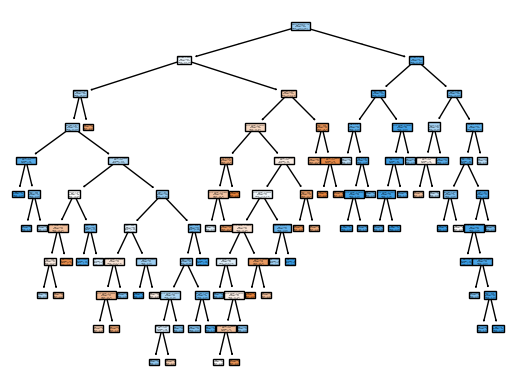

Relatório:
recall (bad): 0.56
accuracy: 0.72


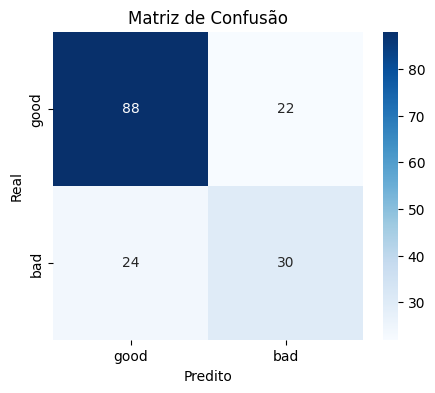

In [ ]:
df_preparado = prepare_all(df.copy())
df_cleaned = df_preparado.dropna(subset=['Saving accounts'])
execute_experiment(df_cleaned, show_tree=True)

Até que remover a coluna `Saving accounts`, ao contrário do que eu esperava, melhorou o modelo. Tanto pelo `recall` quanto pela acurácia (`accuracy`). Contudo, não irei avaliar para os demais cenários mencionados acima pelos fatores mencionados: diminuem consideravelmente a quantidade de dados e alteram a proporção das classes: `good` e `bad`.

#### Missing - Moda

A estratégia que irei experimentar agora será de atribuir o valor da moda aos valores faltantes. Considerando, é claro, a proporção entre as diferentes classes: `good` e `bad`.

/tmp/ipykernel_1519998/2571373263.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[goods_filter, column] = df.loc[goods_filter, column].fillna(good_mode)
/tmp/ipykernel_1519998/2571373263.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[bads_filter, column] = df.loc[bads_filter, column].fillna(bad_mode)
/tmp/ipykernel_1519998/2571373263.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the fut

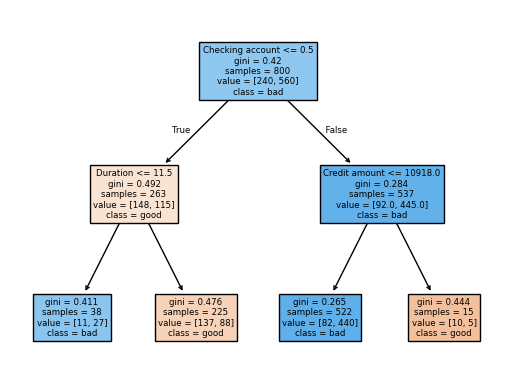

Relatório:
recall (bad): 0.63
accuracy: 0.79


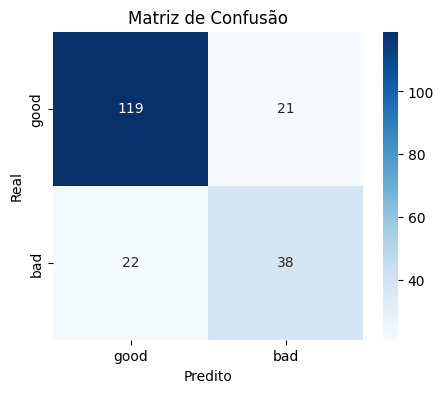

In [ ]:
def fill_with_mode(df, column):
    goods_filter = df['Risk'] == 'good'
    bads_filter = df['Risk'] == 'bad'

    goods = df[goods_filter]
    bads = df[bads_filter]

    good_mode = goods[column].mode()[0]
    bad_mode = bads[column].mode()[0]

    df.loc[goods_filter, column] = df.loc[goods_filter, column].fillna(good_mode)
    df.loc[bads_filter, column] = df.loc[bads_filter, column].fillna(bad_mode)
    
    return df

df_mode_filled = prepare_all(df.copy())
df_mode_filled = fill_with_mode(df_mode_filled, 'Saving accounts')
df_mode_filled = fill_with_mode(df_mode_filled, 'Checking account')

execute_experiment(df_mode_filled, show_tree=True)

Com esse tratamento, o modelo melhorou consideravelmente, tendo aumentado o `recall` para $0.63$ e a acurácia para $0.79$. Além disso, é perceptível, também, como a profuncidade e densidade da árvore mudaram e com isso ela ficou mais simples. Tornando o uso do modelo mais rápido, além de melhor (pelo menos em comparação com os casos anteriores).

Me dou por satisfeito com esse resultado após a limpeza dos dados.

# Exercício 2

Faça uma análise de seleção de variáveis utilizando os métodos que julgar necessários, considerando o tipo de dado. Abaixo uma tabela é indicada para que possa usar como inspiração avaliação de importância composta dos métodos que considerar. 

## Método 1 - Árvore de Decisão

In [ ]:
df_preparado = prepare_all(df.copy())

X = df_preparado.drop('Risk', axis=1)
y = df_preparado['Risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
tree_importances = pd.Series(model.feature_importances_, index=X.columns)
tree_importances.sort_values(ascending=False)


Credit amount          0.195448
Age                    0.189478
Duration               0.155385
Checking account       0.150071
Saving accounts        0.060795
Job                    0.042556
car                    0.032372
furniture/equipment    0.029035
Sex                    0.026972
radio/TV               0.025156
own                    0.018321
education              0.018052
business               0.013373
rent                   0.012579
repairs                0.010924
free                   0.009959
domestic appliances    0.005291
vacation/others        0.004233
dtype: float64

## Método 2 - ANOVA

In [ ]:
df_preparado = prepare_all(df.copy())

df_preparado.dropna(inplace=True)

X = df_preparado.drop('Risk', axis=1)
y = df_preparado['Risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X_train, y_train)
anova_scores = pd.Series(anova_selector.scores_, index=X.columns)
anova_scores.sort_values(ascending=False)

Duration               38.794960
Credit amount          10.636884
Saving accounts         9.207652
Checking account        8.922135
own                     6.505199
rent                    5.108268
Sex                     4.150256
education               2.691121
repairs                 1.826396
radio/TV                1.297288
Age                     1.235157
car                     1.122064
free                    0.795872
vacation/others         0.717230
Job                     0.666234
domestic appliances     0.077968
furniture/equipment     0.041039
business                0.016375
dtype: float64

## Qui-quadrado ($\chi^2$)

In [ ]:
df_preparado = prepare_all(df.copy())

df_preparado.dropna(inplace=True)

X = df_preparado.drop('Risk', axis=1)
y = df_preparado['Risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_train, y_train)
chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns)
chi2_scores.sort_values(ascending=False)


Credit amount          27156.692405
Duration                 262.452894
Saving accounts           15.568178
Checking account           6.117038
Age                        5.123471
rent                       4.109880
Sex                        2.782348
education                  2.538483
own                        2.052624
repairs                    1.787721
radio/TV                   0.990968
car                        0.736138
vacation/others            0.707366
free                       0.694816
Job                        0.165251
domestic appliances        0.077202
furniture/equipment        0.033026
business                   0.014638
dtype: float64

In [ ]:
ranking_df = pd.DataFrame({
    'Decision Tree': tree_importances,
    'ANOVA': anova_scores,
    'Chi2': chi2_scores
})

ranking_df_ranked = ranking_df.rank(ascending=False)
ranking_df_ranked = ranking_df_ranked.sort_values(by=['Decision Tree', 'ANOVA', 'Chi2'], ascending=True)

Após a execução dos seletores acima, temos as seguintes importâncias dos atributos com base em cada seletor.

In [237]:
ranking_df_ranked

,Decision Tree,ANOVA,Chi2
Credit amount,1.0,2.0,1.0
Age,2.0,11.0,5.0
Duration,3.0,1.0,2.0
Checking account,4.0,4.0,4.0
Saving accounts,5.0,3.0,3.0
Job,6.0,15.0,15.0
car,7.0,12.0,12.0
furniture/equipment,8.0,17.0,17.0
Sex,9.0,7.0,7.0
radio/TV,10.0,10.0,11.0


Avaliando a tabela acima, podemos ver a importância de cada atributo e selecionar apenas as ($n$) primeiras $^1$ para treinamento e execução de algum modelo de *machine learning*. Isso para que consideremos apenas os atributos que são, de fato, úteis para o aprendizado e não causem ruídos.

$_{ \text{1. } n \text{ deve ser avaliado para cada cenário }}$